# QPE

This program simulates a quantum circuit for binary addition using the quantum Fourier transform using Qiskit. \
Author: Michal Forgó \
Time: 02.14.2025 \
Note: Ensure you have installed the requirements.txt or environment.yml before running this notebook.

Bitstring: 1011001011010, Count: 38690, Estimated phi: 2pi0.698486328125
Bitstring: 1100101110111, Count: 30692, Estimated phi: 2pi0.7957763671875
Bitstring: 0011000001100, Count: 14553, Estimated phi: 2pi0.18896484375
Bitstring: 1011001011001, Count: 7038, Estimated phi: 2pi0.6983642578125
Bitstring: 1011001011011, Count: 2130, Estimated phi: 2pi0.6986083984375
Bitstring: 1110100010001, Count: 1594, Estimated phi: 2pi0.9083251953125
Bitstring: 1011001011000, Count: 1183, Estimated phi: 2pi0.6982421875
Bitstring: 1011001011100, Count: 673, Estimated phi: 2pi0.69873046875
Bitstring: 1011001010111, Count: 502, Estimated phi: 2pi0.6981201171875
Bitstring: 1011001011101, Count: 332, Estimated phi: 2pi0.6988525390625
{'1110100001000': 2, '1011001011010': 38690, '0011000001100': 14553, '1011001011001': 7038, '1110100010011': 56, '1011001100111': 20, '1010111111000': 2, '1110100101010': 1, '1011000111000': 1, '1100101110111': 30692, '1010001010011': 1, '1011001010101': 144, '1011001011100': 6

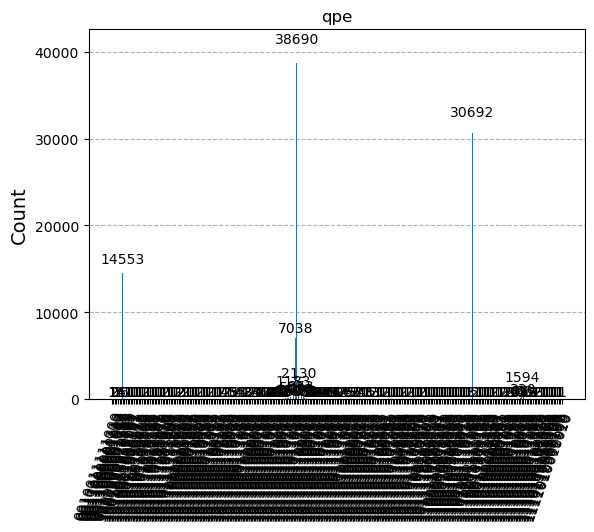

In [ ]:
import numpy as np
from qiskit import QuantumCircuit, transpile
from qiskit.circuit.library import QFT, UnitaryGate
from qiskit_aer import AerSimulator
import scipy.linalg as la
from qiskit.visualization import plot_histogram

# Example usage:
A = np.array([
    [2, 1+1j, 0, -1j],
    [1-1j, 3, 2j, 0],
    [0, -2j, 1, 1],
    [1j, 0, 1, 4]
])

n_count = 13
shots = 100_000
#print(counts)


# Check dimension is a power of 2
n = A.shape[0]
if not (n & (n - 1) == 0) and n != 0:
    raise ValueError("Matrix dimension must be a power of 2.")

# Number of qubits for the target (log2 of dimension)
n_qubits = int(np.log2(n))

# Compute U = exp(iA)
iA = 1j * A
U = la.expm(iA)

# Create Qiskit UnitaryGate for U
gate = UnitaryGate(U, label="exp(iA)")

# Build QPE circuit
qc = QuantumCircuit(n_count + n_qubits, n_count)

# Prepare counting qubits in |+>
qc.h(range(n_count))

# Prepare target register in |1>^⊗n_qubits (simple approach: apply X to all target qubits)
for q in range(n_count, n_count + n_qubits):
    qc.x(q)

# Controlled-U^(2^j) applications
for j in range(n_count):
    # Compute power of U
    powered = gate.power(2**j)
    # Controlled version, control is counting qubit j, targets are the n_qubits starting from n_count
    c_power = powered.control(1)
    qc.append(c_power, [j] + list(range(n_count, n_count + n_qubits)))

# Apply inverse QFT on counting register
qc.append(QFT(n_count, inverse=True, name="QFT†"), range(n_count))

# Measure counting qubits
qc.measure(range(n_count), range(n_count))

# Simulate
simulator = AerSimulator(shots=shots)
compiled = transpile(qc, simulator)
job = simulator.run(compiled)
result = job.result()

counts = result.get_counts(compiled)


# Plot histogram (can be commented out if running in non-graphical environment)
k = 10  # number of most likely phases you want
sorted_counts = sorted(counts.items(), key=lambda item: item[1], reverse=True)
top_k = sorted_counts[:k]

for bitstring, count in top_k:
    estimated_phi = int(bitstring, 2) / 2**n_count
    print(f"Bitstring: {bitstring}, Count: {count}, Estimated phi: 2pi*{estimated_phi}")

print(counts)
plot_histogram(counts, title=f"qpe")



